In [ ]:
!pip install -q git+https://github.com/upb-lea/gym-electric-motor.git

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 626.2/626.2 kB 8.6 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 958.1/958.1 kB 29.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 234.7/234.7 kB 10.7 MB/s eta 0:00:00


In [ ]:
!git clone https://github.com/upb-lea/gym-electric-motor.git

Cloning into 'gym-electric-motor'...
remote: Enumerating objects: 14998, done.
remote: Counting objects: 100% (4594/4594), done.
remote: Compressing objects: 100% (1011/1011), done.
remote: Total 14998 (delta 3630), reused 4466 (delta 3549), pack-reused 10404 (from 1)
Receiving objects: 100% (14998/14998), 31.83 MiB | 43.12 MiB/s, done.
Resolving deltas: 100% (11535/11535), done.


In [ ]:
!ls /content/gym-electric-motor/examples/classic_controllers/

classic_controllers_dc_motor_example.py		custom_classic_controllers_ind_motor_example.py
classic_controllers_ind_motor_example.py	custom_classic_controllers_synch_motor_example.py
classic_controllers.py				externally_referenced_state_plot.py
classic_controllers_synch_motor_example.py	external_plot.py
controllers					integration_test_classic_controllers_dc_motor.py
custom_classic_controllers_dc_motor_example.py


In [ ]:
import sys
sys.path.append('/content/gym-electric-motor/examples/classic_controllers/')
sys.path.append('/content/gym-electric-motor/examples/classic_controllers/controllers')

Processo da Simulação: 100%|███████████████████████████████| 132000/132000 [05:12<00:00, 422.97it/s]


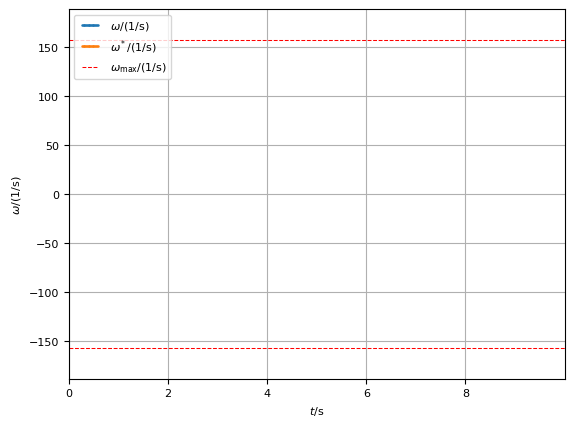

In [ ]:
from classic_controllers import Controller
from externally_referenced_state_plot import ExternallyReferencedStatePlot
import gym_electric_motor as gem
from gym_electric_motor.visualization import MotorDashboard
from gym_electric_motor.physical_systems import ContB6BridgeConverter
from gym_electric_motor.physical_systems import ScipyOdeSolver

import numpy as np
import matplotlib.pyplot as plt
import time
from tqdm import tqdm

if __name__ == '__main__':

    motor_type = 'PMSM'
    control_type = 'SC'
    action_type = 'Cont'

    env_id = action_type + '-' + control_type + '-' + motor_type + '-v0'

    # Parametros da Maquina IPMSM
    omega_limit = 1.5e3
    torque_limite = 32
    corrente_limite = 24
    tensao_barramento = 400
    limit_values = dict(omega=omega_limit * np.pi / 30, torque=torque_limite, i=corrente_limite, u=tensao_barramento)
    nominal_values = dict(omega=omega_limit * np.pi / 30, torque=torque_limite, i=corrente_limite, epsilon=np.pi, u=tensao_barramento)
    motor_parameter = dict(p=4, l_d=14e-3, l_q=19e-3, j_rotor=0.006, r_s=1.176, psi_p=0.438)

    # Definicao dos parametro para plot automatico
    states = ['omega', 'torque', 'i_a', 'i_b', 'i_c', 'u_b', 'u_a', 'u_c']
    external_ref_plots = [ExternallyReferencedStatePlot(state) for state in ['omega']]

    # Parametros Dinamicos do Kart
    M = 156+13.5# Massa do sistema kart+piloto 22.5kg de inicio posteriormente 13.5kg
    g = 9.81# Aceleração da Gravidade
    fr = 2.2e-2# Coeficiente de Resistencia do Rolamento
    angulo_alpha = np.radians(0)# Angulo de aclive
    eta_t = 0.98# Rendimento Transmissao

    ro = 1.225#Densidade do Ar
    A_f = 0.65#Area frontal
    C_d = 0.75#Coeficiente de arrasto
    r_d = 0.14#Raio das rodas

    # Calculo da Relação de Velocidade de acordo com os 62km/h ou 17.4 m/s
    i_g = (omega_limit * np.pi * r_d) / (30 * 18.9)
    i_g = round(i_g, 1)

    # Com Carga na Simulação - Dinâmica do Kart
    a_torque = r_d*M * g * (fr * np.cos(angulo_alpha) + np.sin(angulo_alpha))/(i_g * eta_t)
    b_torque = 0
    c_torque = (0.5 * ro * A_f * C_d * (r_d**3))/(eta_t * i_g**3)
    j_torque = (M*r_d**2)/(eta_t * i_g**2)

    # Inicializacao e criacao do ambiente de simulacao
    env = gem.make(env_id, visualization=MotorDashboard(additional_plots=external_ref_plots),
                   motor=dict(limit_values=limit_values,
                              nominal_values=nominal_values,
                              motor_parameter=motor_parameter
                   ),
                   render_mode = 'figure_once',
                   load=gem.physical_systems.PolynomialStaticLoad(dict(a = a_torque, b = b_torque, c = c_torque, j_load=j_torque)),
                   supply = dict(u_nominal=tensao_barramento),
                   converter = ContB6BridgeConverter(),
                   tau=10e-4)

    tau = env.physical_system.tau
    limits = env.physical_system.limits

    # Parametros do Controlador em Cascata de Velocidade e Corrente dq
    current_d_controller = {'controller_type': 'pi_controller', 'p_gain': 1.5, 'i_gain': 160}
    current_q_controller = {'controller_type': 'pi_controller', 'p_gain': 1.5, 'i_gain': 160}
    speed_controller = {'controller_type': 'pi_controller', 'p_gain': 75, 'i_gain': 180}

    current_controller = [current_d_controller, current_q_controller]
    overlaid_controller = [speed_controller]

    stages = [current_controller, overlaid_controller]

    # Criacao do controlador
    controller = Controller.make(env, stages=stages, external_ref_plots=external_ref_plots, torque_control='analytical')

    (state, reference), _ = env.reset()

    # Preparação da Referencia de Velocidade
    vetor = [
                  0, 4.52443600000000, 7.28576800000000, 9.99154000000000, 9.99154000000000,
                  14.5845000000000, 18.2070120000000, 18.9515160000000, 19.7997320000000, 22.2499280000000,
                  25.5261160000000, 24.8371720000000, 24.8371720000000, 23.7167120000000, 24.8001320000000,
                  25.4242560000000, 26.0372680000000, 25.7168720000000, 25.8891080000000, 26.4224840000000,
                  26.4224840000000, 28.7560040000000, 29.0782520000000, 29.5282880000000, 30.8246880000000,
                  30.6987520000000, 32.8563320000000, 32.9878240000000, 32.9878240000000, 33.8045560000000,
                  39.6327999999999, 46.5315000000000, 48.4186879999999, 52.7245880000000, 57.5823840000000,
                  60.8382000000000, 60.8382000000000, 61.7290120000000, 60.1251800000000, 56.0748560000000,
                  51.1911319999999, 45.9888640000000, 41.6440720000000, 44.9424840000000, 44.9424840000000,
                  47.5019480000000, 48.5131400000000, 50.6929440000000, 51.2374320000000, 52.9542360000000,
                  53.8876440000000, 52.4856800000000, 52.4856800000000, 46.2537000000000, 35.1583680000000,
                  38.6216080000000, 36.5695920000000, 40.3124840000000, 43.2701280000000, 47.2185920000000,
                  47.2185920000000, 51.8374800000000, 54.4747280000000, 57.5231200000000, 58.7472920000000,
                  61.0196960000000, 63.2680240000000, 62.8605840000000, 62.8605840000000, 63.2846920000000,
                  65.2441080000000, 67.2924200000000, 65.9293479999999, 66.3219720000000
            ]

    vetor_2 = [
                  66.3219720000000, 66.4886520000000, 65.4941280000000, 65.4941280000000,
                  65.7330360000000, 62.1012639999999, 58.3028120000000, 57.6842440000000,
                  57.2953240000000, 54.0339520000000, 49.1483760000000, 49.1483760000000,
                  39.6235400000000, 35.5750680000000, 39.1383160000000, 41.6922240000000,
                  48.2520080000000, 54.5080640000000, 59.5455040000000, 59.5455040000000,
                  61.7604960000000, 62.5994520000000, 63.5254520000000, 60.2011120000000,
                  46.7037360000000, 43.4868120000000, 44.6498680000000, 44.6498680000000,
                  46.7167000000000, 48.7353800000000, 50.5281160000000, 51.6689480000000,
                  53.5209480000000, 54.3376800000000, 55.2099720000000, 55.2099720000000,
                  52.8283000000000, 45.4073360000000, 41.0273560000000, 41.4422040000000,
                  40.6365840000000, 44.3646600000000, 49.0872600000000, 49.0872600000000,
                  50.3818080000000, 52.9634960000000, 57.5620120000000, 58.0509400000000,
                  62.0475560000000, 62.0568160000000, 63.9921560000000, 63.9921560000000,
                  64.3292200000000, 64.6699880000000, 67.7813480000000, 66.6960760000000,
                  65.7108120000000, 66.6201440000000
              ]

    # Preparacao dos dados do Ciclo de conducao
    teste = vetor + vetor_2
    time_horizon = len(teste)
    vetor = teste[:time_horizon+1]
    vetor_arredondado = [round(num, 2) for num in vetor]
    t = np.linspace(0, time_horizon, time_horizon)
    t_maior = np.linspace(0, time_horizon, time_horizon*1000+1)
    velocidade_nova = np.interp(t_maior, t, vetor_arredondado)

    # Definicao do Tempo Total de Simulacao
    step_horizon = int(time_horizon / tau)

    STATE = np.transpose(np.array([state[0]*limits]))
    TIME = np.array([0])

    # Preparacao de Variaveis de Referencia
    referencia = np.zeros(step_horizon + 1)
    referencia = velocidade_nova
    referencia = referencia * (i_g/(3.6*r_d))
    referencia = referencia / (omega_limit * np.pi / 30)

    # Criando um vetor para corrente de barramento CC
    i_sup = np.zeros(step_horizon + 1)

    with tqdm(total=step_horizon, desc="Processo da Simulação", unit="it", ncols=100, bar_format="{l_bar}{bar}| {n_fmt}/{total_fmt} [{elapsed}<{remaining}, {rate_fmt}]") as pbar:
        for i in range(step_horizon):
            time = i * tau
            reference = referencia[i]

            action = controller.control(state, [reference])
            (state, reference), reward, terminated, truncated, _ = env.step(action)

            STATE = np.append(STATE, np.transpose([state * limits]), axis=1)
            TIME = np.append(TIME, time)
            pbar.update(1)

            i_a_teste = np.array(STATE[2,i])
            i_b_teste = np.array(STATE[3,i])
            i_c_teste = np.array(STATE[4,i])
            i_sup[i] = env.physical_system.converter.i_sup([i_a_teste,i_b_teste,i_c_teste])

            if terminated:
                env.reset()
                controller.reset()
                break

    env.close()

# STATE[0]: omega (Velocidade Angular Mecanica)
# STATE[1]: T (Torque)
# STATE[2] - STATE[4]: i_sa, i_sb, i_sc (Correntes de Fase do Estator)
# STATE[5] - STATE[6]: i_sd, i_sq (Correntes de Estator em dq)
# STATE[7] - STATE[9]: u_sa, u_sb, u_sc (Tensoes de Fase do Estator)
# STATE[10] - STATE[11]: u_sd, u_sq (Tensoes de Fase do Estator em dq)
# STATE[12]: epsilon (Posicao Angular do Rotor)
# STATE[13]: u_sup (Tensao do Barramento CC)

In [ ]:
omega_referencia = referencia * (omega_limit * np.pi / 30)
Fig_tamanho = (12, 8)

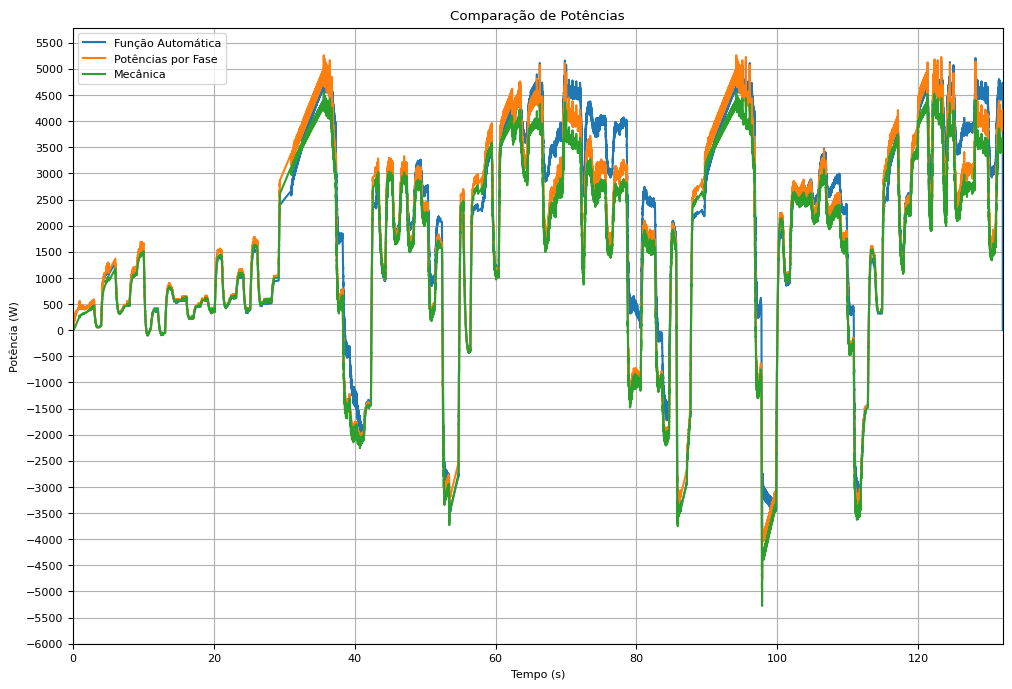

In [ ]:
P_teste = i_sup * tensao_barramento
P_a = np.array(STATE[2]*STATE[7])
P_b = np.array(STATE[3]*STATE[8])
P_c = np.array(STATE[4]*STATE[9])
P_entrada = P_a + P_b + P_c
potencia = STATE[0]*STATE[1]
# Plot Torque
plt.figure(figsize=Fig_tamanho)
plt.rcParams.update({'font.size': 8})
plt.plot(TIME, P_teste, label="Função Automática")
plt.plot(TIME, P_entrada, label="Potências por Fase")
plt.plot(TIME, potencia, label="Mecânica")
plt.yticks(np.arange(-6000, 6000, step=500))
plt.ylabel(r"Potência (W)")
plt.xlabel(r"Tempo (s)")
plt.xlim([TIME[0], TIME[-1]])
plt.grid()
plt.title("Comparação de Potências")
plt.legend()
plt.show()

In [ ]:
# Salvando os Dados
np.save('PMSM_STATE_Carga.npy', STATE)
np.save('PMSM_TIME_Carga.npy', TIME)
np.save('PMSM_REF_Carga.npy', omega_referencia)
np.save('PMSM_HOZ_Carga.npy', step_horizon)

In [ ]:
# Carregando os dados do STATE
import numpy as np
STATE = np.load('PMSM_STATE_Carga.npy')
TIME = np.load('PMSM_TIME_Carga.npy')
omega_referencia = np.load('PMSM_REF_Carga.npy')
step_horizon = np.load('PMSM_HOZ_Carga.npy')

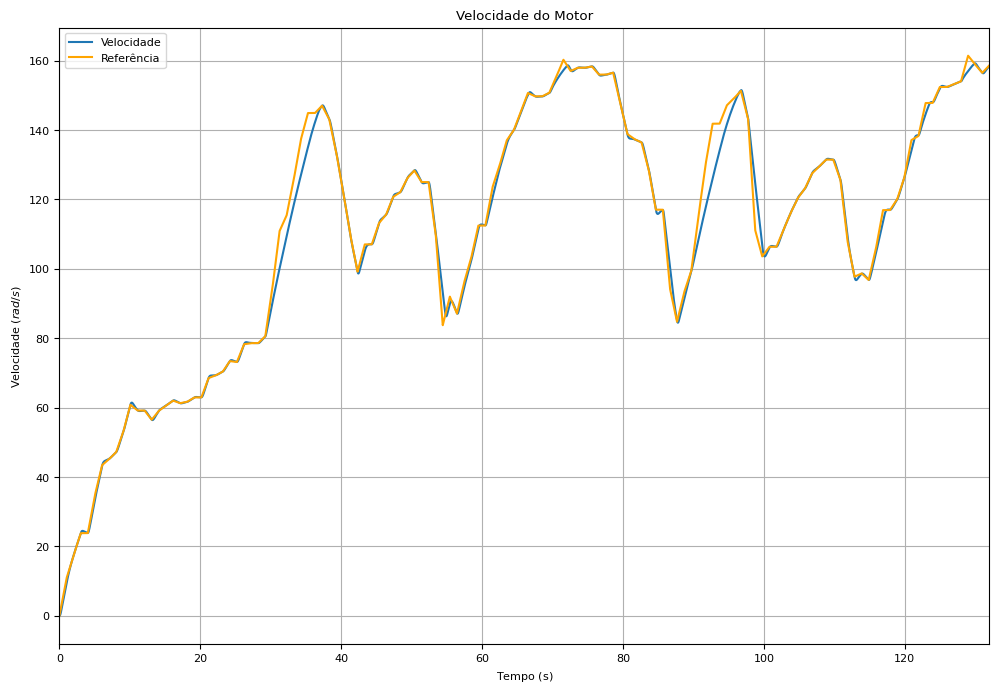

In [ ]:
#omega_referencia = referencia * (omega_limit * np.pi / 30) #* convert_velocidade
Fig_tamanho = (12, 8)
import matplotlib.pyplot as plt
# Plot Vel_rad/s
plt.figure(figsize=Fig_tamanho)
plt.rcParams.update({'font.size': 8})
plt.plot(TIME, STATE[0], label="Velocidade")
plt.plot(TIME, omega_referencia, label="Referência", color='orange')
plt.ylabel(r"Velocidade ($rad/s$)")
plt.xlabel(r"Tempo ($\mathrm{s}$)")
plt.xlim([TIME[0], TIME[-1]])
plt.grid()
plt.title("Velocidade do Motor")
plt.legend()
plt.show()

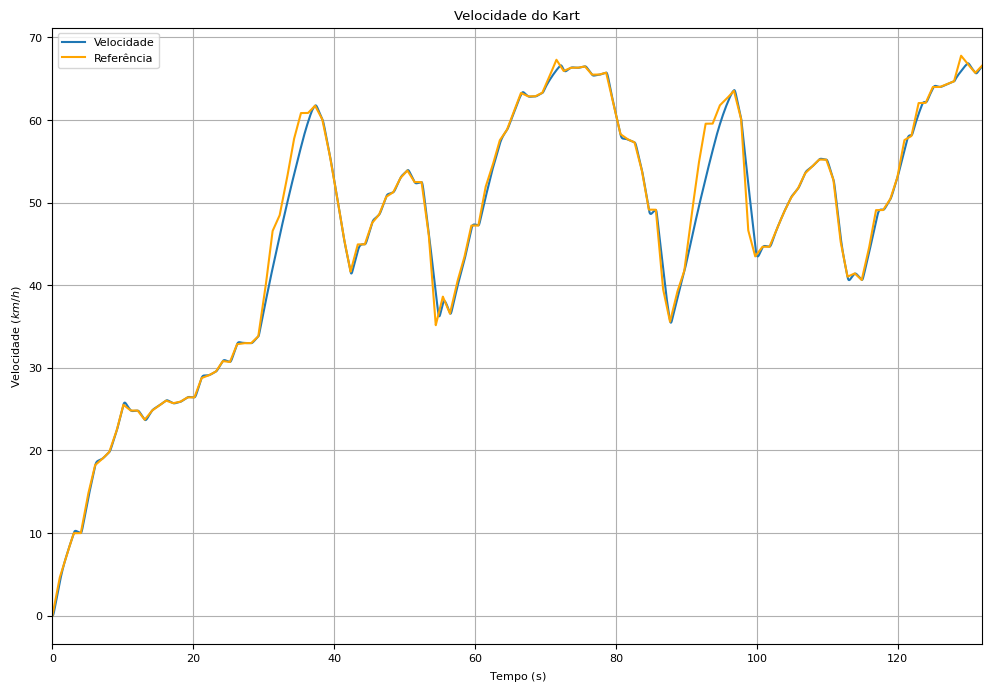

In [ ]:
# Plot Vel_m/s
r_d = 0.14
#i_g = 1.16
vel_kmh = 3.6*STATE[0]*r_d/ i_g
vel_ref = 3.6*omega_referencia*r_d/ i_g
plt.figure(figsize=Fig_tamanho)
plt.rcParams.update({'font.size': 8})
plt.plot(TIME, vel_kmh, label="Velocidade")
plt.plot(TIME, vel_ref, label="Referência", color='orange')
plt.ylabel(r"Velocidade ($km/h$)")
plt.xlabel(r"Tempo ($\mathrm{s}$)")
plt.xlim([TIME[0], TIME[-1]])
plt.grid()
plt.title("Velocidade do Kart")
plt.legend()
plt.show()

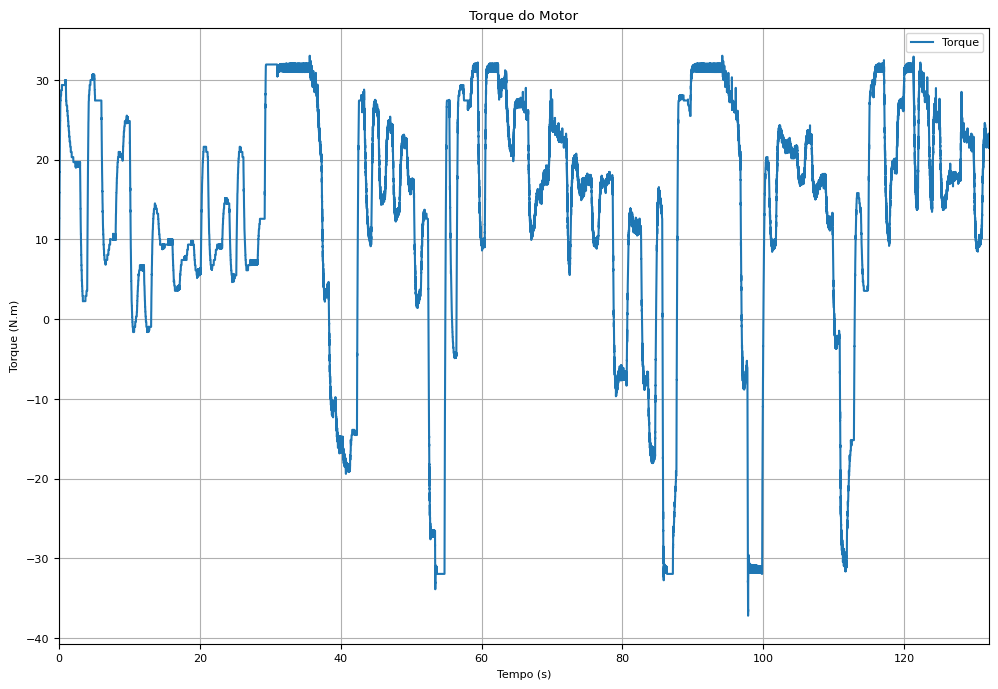

In [ ]:
# Plot Torque
plt.figure(figsize=Fig_tamanho)
plt.rcParams.update({'font.size': 8})
plt.plot(TIME, STATE[1], label="Torque")
plt.ylabel(r"Torque (N.m)")
plt.xlabel(r"Tempo (s)")
plt.xlim([TIME[0], TIME[-1]])
plt.grid()
plt.title("Torque do Motor")
plt.legend()
plt.show()

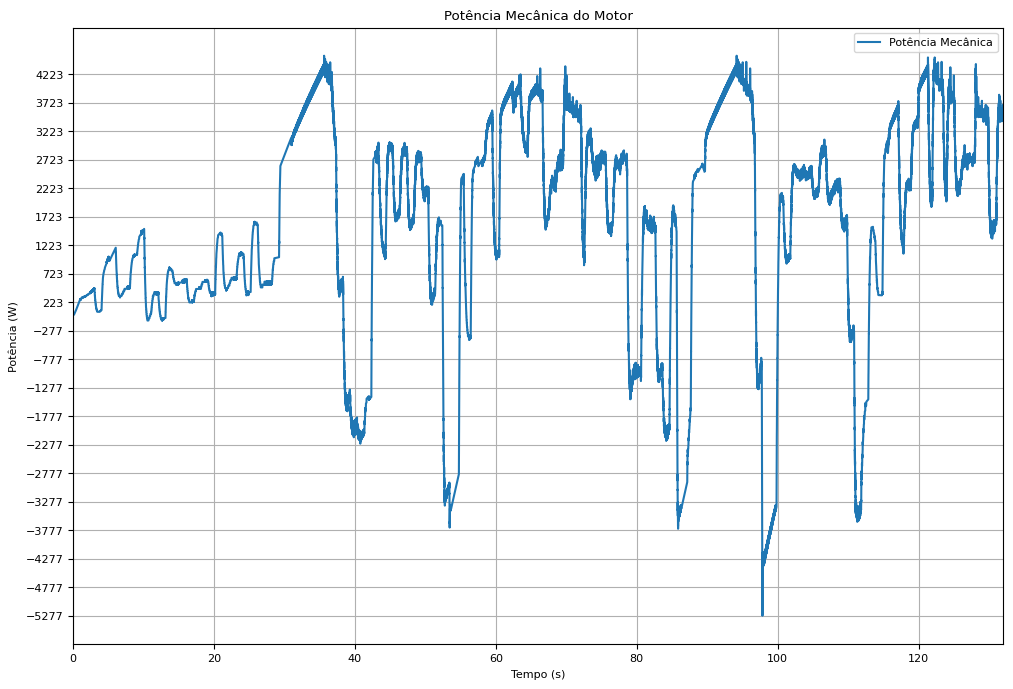

In [ ]:
# Plot Potência de saída do Motor
potencia = STATE[0]*STATE[1]
plt.figure(figsize=Fig_tamanho)
plt.rcParams.update({'font.size': 8})
plt.plot(TIME, potencia, label="Potência Mecânica")
plt.ylabel(r"Potência (W)")
plt.xlabel(r"Tempo (s)")
plt.xlim([TIME[0], TIME[-1]])
plt.yticks(np.arange(min(potencia), max(potencia), step=500))
plt.grid()
plt.title("Potência Mecânica do Motor")
plt.legend()
plt.show()

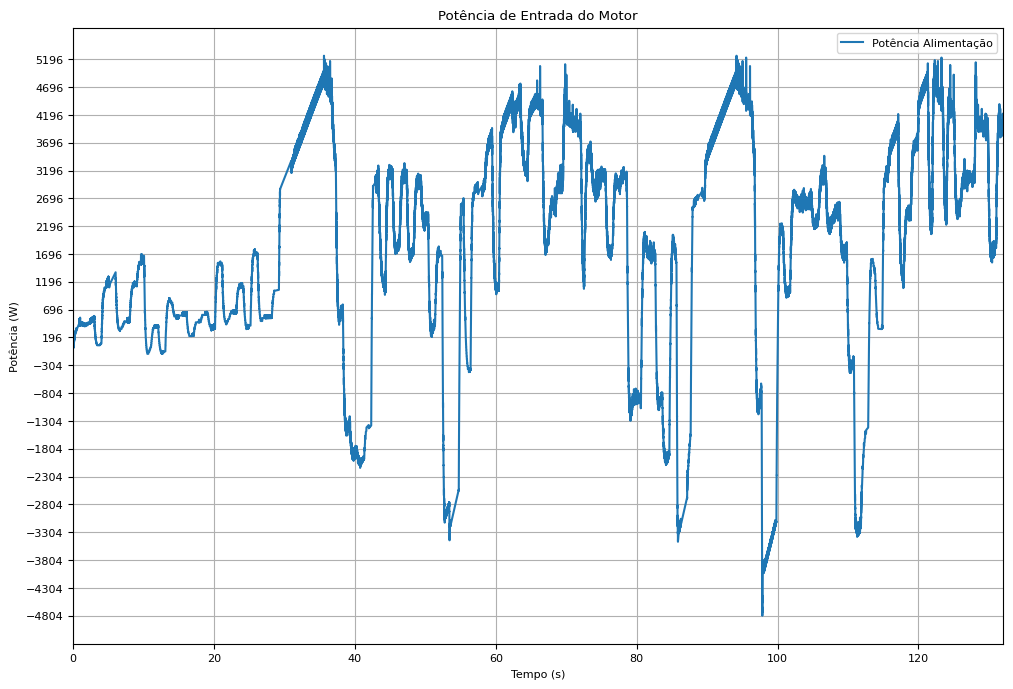

In [ ]:
# Cálculo das Potência de Entrada do Motor
P_a = np.array(STATE[2]*STATE[7])
P_b = np.array(STATE[3]*STATE[8])
P_c = np.array(STATE[4]*STATE[9])

P_entrada = (P_a + P_b + P_c)

plt.figure(figsize=Fig_tamanho)
plt.rcParams.update({'font.size': 8})
plt.plot(TIME, P_entrada, label="Potência Alimentação")
plt.ylabel(r"Potência (W)")
plt.xlabel(r"Tempo (s)")
plt.xlim([TIME[0], TIME[-1]])
plt.yticks(np.arange(min(P_entrada), max(P_entrada), step=500))
plt.grid()
plt.title("Potência de Entrada do Motor")
plt.legend()
plt.show()

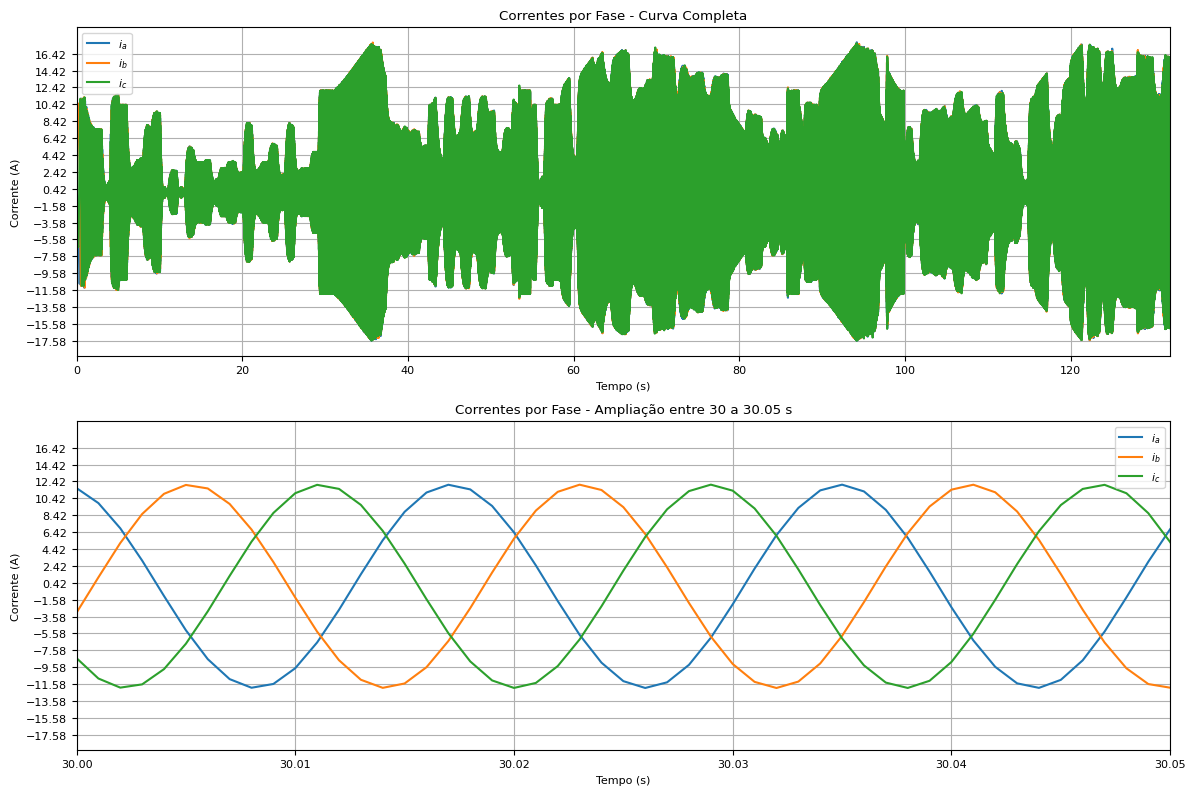

In [ ]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=Fig_tamanho)
plt.rcParams.update({'font.size': 8})

# Primeiro subplot
ax1.plot(TIME, STATE[2], label="$i_a$")
ax1.plot(TIME, STATE[3], label="$i_b$")
ax1.plot(TIME, STATE[4], label="$i_c$")
ax1.set_ylabel(r"Corrente (A)")
ax1.set_xlabel(r"Tempo (s)")
ax1.set_xlim([TIME[0], TIME[-1]])
ax1.set_yticks(np.arange(min(STATE[4]), max(STATE[4]), step=2))
ax1.grid()
ax1.set_title("Correntes por Fase - Curva Completa")
ax1.legend()

# Segundo subplot
ax2.plot(TIME, STATE[2], label="$i_a$")
ax2.plot(TIME, STATE[3], label="$i_b$")
ax2.plot(TIME, STATE[4], label="$i_c$")
ax2.set_ylabel(r"Corrente (A)")
ax2.set_xlabel(r"Tempo (s)")
ax2.set_xlim([30, 30.05])
ax2.set_yticks(np.arange(min(STATE[4]), max(STATE[4]), step=2))
ax2.grid()
ax2.set_title("Correntes por Fase - Ampliação entre 30 a 30.05 s")
ax2.legend()

plt.tight_layout()
plt.show()

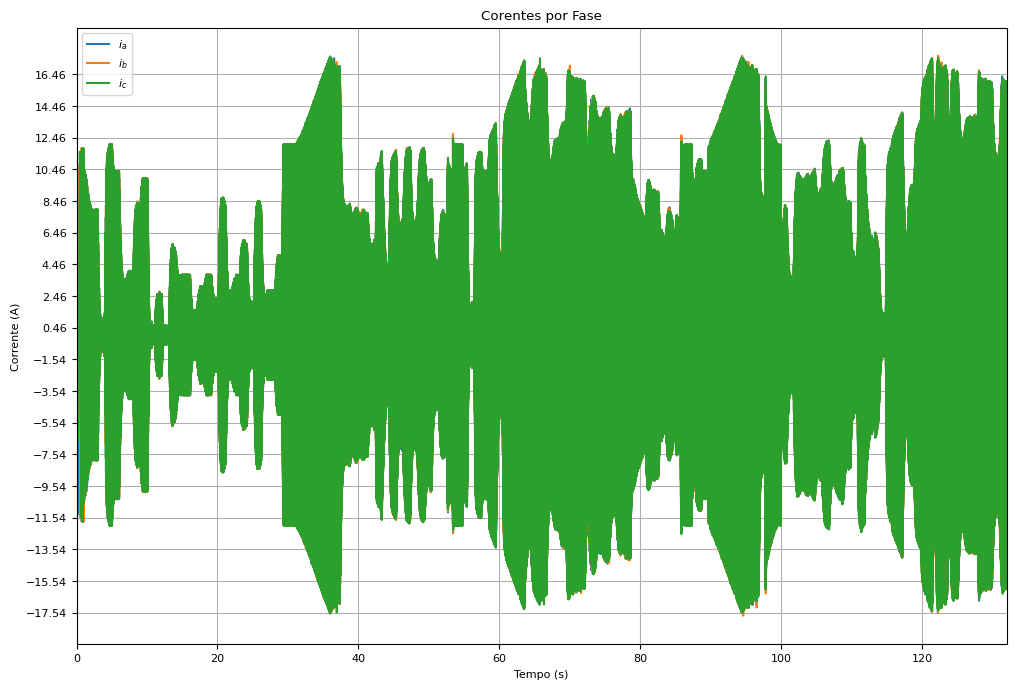

In [ ]:
# Plot das Correntes do Motor
plt.figure(figsize=Fig_tamanho)
plt.rcParams.update({'font.size': 8})
plt.plot(TIME, STATE[2], label="$i_a$")
plt.plot(TIME, STATE[3], label="$i_b$")
plt.plot(TIME, STATE[4], label="$i_c$")
plt.ylabel(r"Corrente (A)")
plt.yticks(np.arange(min(STATE[4]), max(STATE[4]), step=2))
plt.xlabel(r"Tempo (s)")
plt.xlim([TIME[0], TIME[-1]])
plt.grid()
plt.title("Corentes por Fase")
plt.legend()
plt.show()

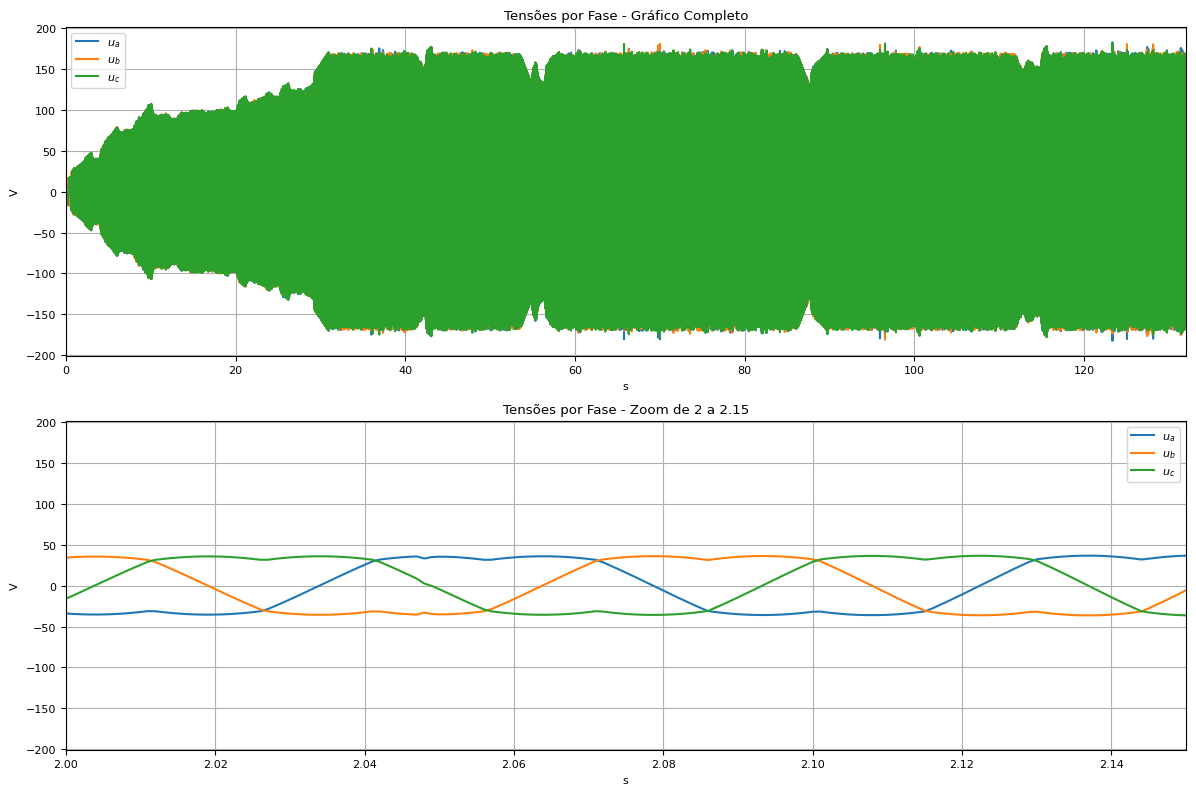

In [ ]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=Fig_tamanho)
plt.rcParams.update({'font.size': 8})

# Primeiro subplot
ax1.plot(TIME, STATE[7], label="$u_a$")
ax1.plot(TIME, STATE[8], label="$u_b$")
ax1.plot(TIME, STATE[9], label="$u_c$")
ax1.set_ylabel(r"V")
ax1.set_xlabel(r"$\mathrm{s}$")
ax1.set_xlim([TIME[0], TIME[-1]])
ax1.grid()
ax1.set_title("Tensões por Fase - Gráfico Completo")
ax1.legend()

# Segundo subplot
ax2.plot(TIME, STATE[7], label="$u_a$")
ax2.plot(TIME, STATE[8], label="$u_b$")
ax2.plot(TIME, STATE[9], label="$u_c$")
ax2.set_ylabel(r"V")
ax2.set_xlabel(r"$\mathrm{s}$")
ax2.set_xlim([2, 2.15])
ax2.grid()
ax2.set_title("Tensões por Fase - Zoom de 2 a 2.15")
ax2.legend()

plt.tight_layout()
plt.show()


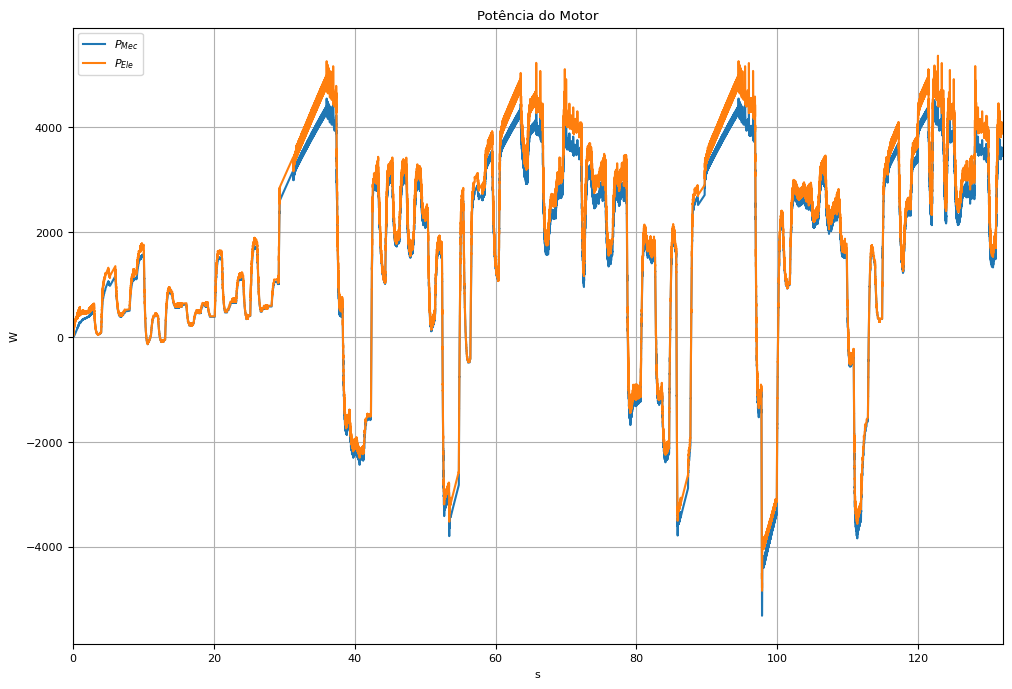

In [ ]:
plt.figure(figsize=Fig_tamanho)
plt.rcParams.update({'font.size': 8})
plt.plot(TIME, potencia, label="$P_{Mec}$")
plt.plot(TIME, P_entrada, label="$P_{Ele}$")
plt.ylabel(r"W")
plt.xlabel(r"$\mathrm{s}$")
plt.xlim([TIME[0], TIME[-1]])
plt.grid()
plt.title("Potência do Motor")
plt.legend()
plt.show()

In [ ]:
potencia_entrada_media = np.mean(P_entrada)
potencia_saida_media = np.mean(potencia)
rendimento = potencia_saida_media/potencia_entrada_media
rendimento_2 = potencia[8055]/P_entrada[8055]
rendimento

0.8831531696715985

In [ ]:
# Diminuindo a Simulação
def reduce_vector_size(vector, reduction_factor):
    new_size = len(vector) // reduction_factor

    reduced_vector = np.zeros(new_size)

    for i in range(new_size):
        start_index = i * reduction_factor
        end_index = start_index + reduction_factor
        reduced_vector[i] = np.mean(vector[start_index:end_index])

    return reduced_vector

def reduce_time(vector,reduction_factor):
  new_size = len(vector) // reduction_factor
  reduced_time = np.linspace(vector[0], vector[-1], new_size)
  return reduced_time



In [ ]:
# tensao_barramento = 400
reduction_factor = 500
I_Barramento = P_entrada/tensao_barramento
I_Barramento = I_Barramento/0.95# Rendimento do Inversor
I_Barramento = I_Barramento*6.4# Rendimento Conversor Dc/Dc da bateria
reduced_vector = reduce_vector_size(I_Barramento, reduction_factor)
reduced_timer = reduce_time(TIME,reduction_factor)
print(len(reduced_vector))
print(len(reduced_timer))

264
264


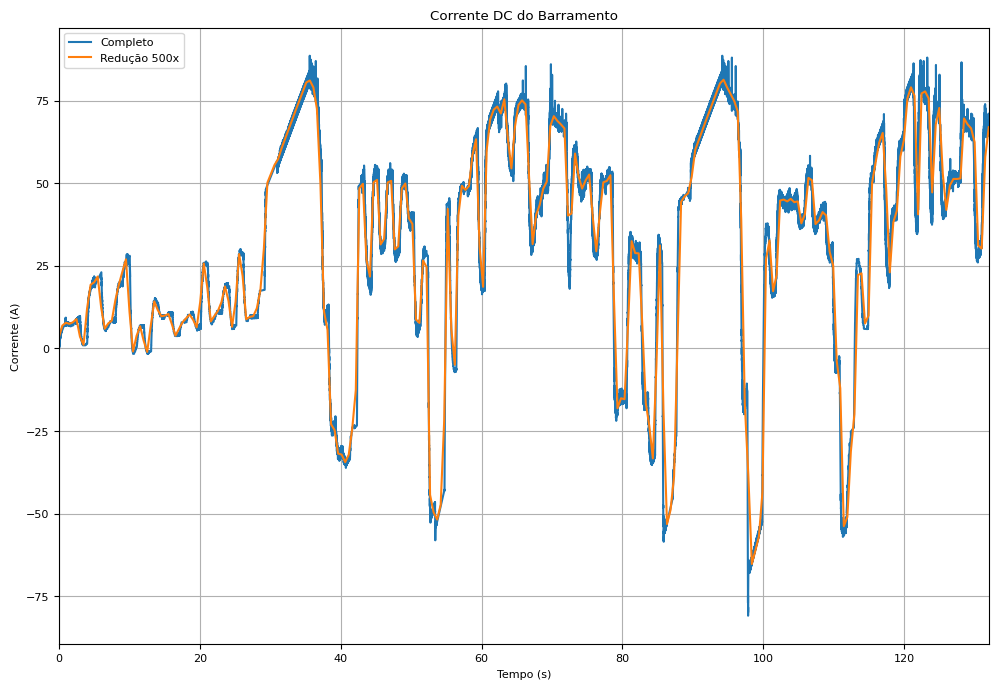

In [ ]:
# Plot Corrente dc do Barramento
plt.figure(figsize=Fig_tamanho)
plt.rcParams.update({'font.size': 8})
plt.plot(TIME, I_Barramento, label="Completo")
plt.plot(reduced_timer, reduced_vector, label="Redução 500x")
plt.ylabel(r"Corrente (A)")
plt.xlabel(r"Tempo (s)")
plt.xlim([reduced_timer[0], reduced_timer[-1]])
plt.grid()
plt.title("Corrente DC do Barramento")
plt.legend()
plt.show()

In [ ]:
Volta_corrida = reduced_vector[185:]# 925 para 100x #92 para 1000x # 185 para 500x
print(len(Volta_corrida))

79


In [ ]:
Corrida = []
Voltas = 14#treino 7  corrida 14
for m in range(Voltas):
  Corrida = np.concatenate((Corrida,Volta_corrida))
print(len(Corrida))

1106


In [ ]:
# 58 segundos por volta
tempo_corrida = np.linspace(132, 132+58*Voltas, len(Corrida))
print(len(tempo_corrida))

1106


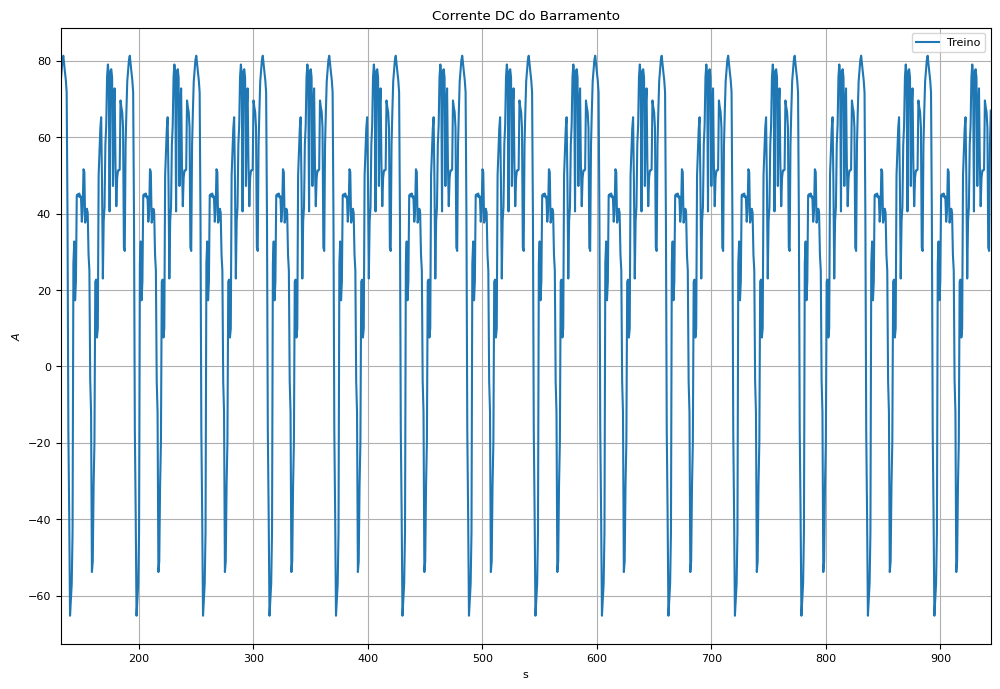

In [ ]:
# Plot Corrente dc do Barramento
plt.figure(figsize=Fig_tamanho)
plt.rcParams.update({'font.size': 8})
plt.plot(tempo_corrida, Corrida, label="Treino")
plt.ylabel(r"$A$")
plt.xlabel(r"$\mathrm{s}$")
plt.xlim([tempo_corrida[0], tempo_corrida[-1]])
plt.grid()
plt.title("Corrente DC do Barramento")
plt.legend()
plt.show()

In [ ]:
Total_Corrida = np.concatenate((reduced_vector,Corrida))
print(len(Total_Corrida))

Total_tempo = np.concatenate((reduced_timer,tempo_corrida))
print(len(Total_tempo))

1370
1370


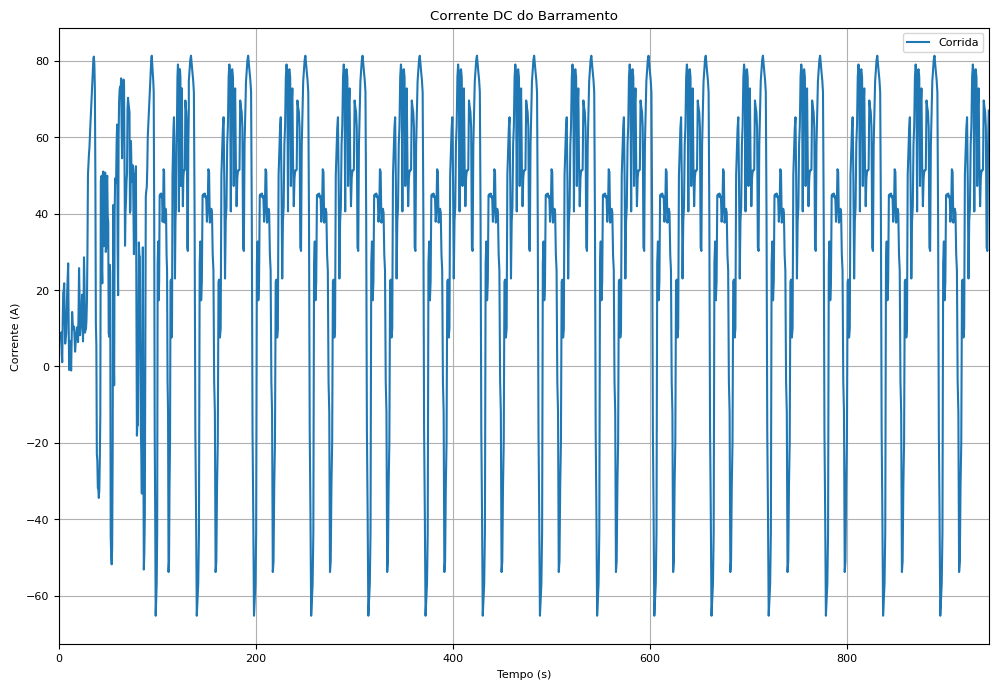

In [ ]:
# Plot Corrente dc do Barramento
plt.figure(figsize=Fig_tamanho)
plt.rcParams.update({'font.size': 8})
plt.plot(Total_tempo, Total_Corrida, label="Corrida")
plt.ylabel(r"Corrente (A)")
plt.xlabel(r"Tempo (s)")
plt.xlim([Total_tempo[0], Total_tempo[-1]])
plt.grid()
plt.title("Corrente DC do Barramento")
plt.legend()
plt.show()

In [ ]:
!pip install pybamm
!pip install liionpack

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.5/16.5 MB 96.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.9/44.9 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.4/73.4 MB 16.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 49.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.5/52.5 kB 1.9 MB/s eta 0:00:00
  Using cached jedi-0.19.1-py2.py3-none-any.whl.metadata (22 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.6/22.6 MB 85.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 435.0/435.0 kB 23.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 250.9/250.9 kB 15.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.6/65.6 MB 18.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 261.3/261.3 kB 16.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.8/49.8 kB 3.2 MB/s eta 0:00:00
Using cached jedi-0.19.1-py2.py3-none-any.whl (1.6 MB)
   ━━━━━

In [ ]:
import liionpack as lp
import pybamm
import matplotlib.pyplot as plt
import numpy as np

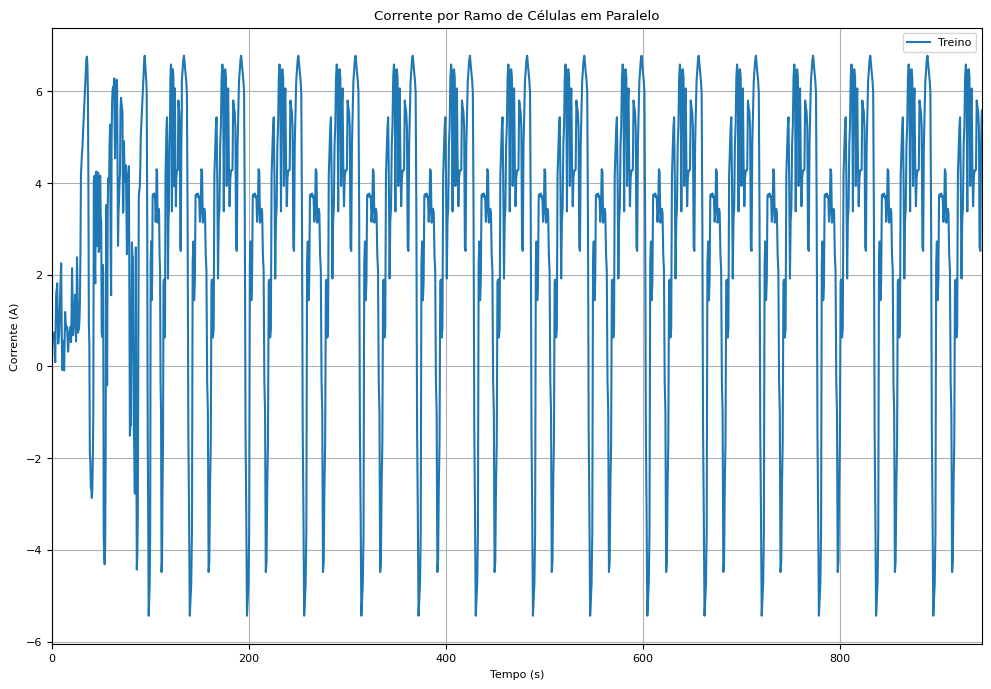

In [ ]:
Total_Corrida_R = Total_Corrida/12#12 processo Final inicio é 20

# Plot Corrente dc do Barramento
plt.figure(figsize=Fig_tamanho)
plt.rcParams.update({'font.size': 8})
plt.plot(Total_tempo, Total_Corrida_R, label="Treino")
plt.ylabel(r"Corrente (A)")
plt.xlabel(r"Tempo (s)")
plt.xlim([Total_tempo[0], Total_tempo[-1]])
plt.grid()
plt.title("Corrente por Ramo de Células em Paralelo")
plt.legend()
plt.show()

In [ ]:
model = pybamm.lithium_ion.DFN()

parameter_values = pybamm.ParameterValues("Chen2020")

parameter_values.update(
    {"Number of cells connected in series to make a battery": 1})
parameter_values.update(
    {"Number of electrodes connected in parallel to make a cell": 1})
parameter_values.update(
    {"Open-circuit voltage at 0% SOC [V]": 2.5})
parameter_values.update(
    {"Open-circuit voltage at 100% SOC [V]": 4.2})
parameter_values.update(
    {"Nominal cell capacity [A.h]": 2.5})
parameter_values.update(
    {"Current function [A]": Total_Corrida/12})# 20 ou 12

# drive_cycle_power = np.column_stack([reduced_timer, reduced_vector])
# drive_cycle_power = np.column_stack([tempo_corrida, Corrida])
drive_cycle_power = np.column_stack([Total_tempo, Total_Corrida_R])
experiment = pybamm.Experiment([pybamm.step.current(drive_cycle_power)],
    period="0.5 second")# Para 100x 0.1     para 1000x 1   para 500x 0.5

fast_solver = pybamm.CasadiSolver(atol=1e-4, rtol=1e-5, mode="fast")

sim = pybamm.Simulation(model, experiment=experiment, parameter_values=parameter_values, solver = fast_solver)

sim.solve(initial_soc=SoC_final_Treino)

solution = sim.solution

In [ ]:
Corrente_Celula_Treino = solution['Current [A]'].entries
Capacidade_Treino = solution['Discharge capacity [A.h]'].entries
Tensao_Celula_Treino = solution['Voltage [V]'].entries
t_Treino = solution["Time [s]"].entries

In [ ]:
np.save('Bateria_Corrente_Celula_Treino.npy', Corrente_Celula_Treino)
np.save('Bateria_t_Treino.npy', t_Treino)
np.save('Bateria_Capacidade_Treino.npy', Capacidade_Treino)
np.save('Bateria_Tensao_Celula_Treino.npy', Tensao_Celula_Treino)
np.save('Bateria_SoC_Final_Treino.npy', SoC_final_Treino)

In [ ]:
Corrente_Celula_Treino = np.load('Bateria_Corrente_Celula_Treino.npy')
t_Treino = np.load('Bateria_t_Treino.npy')
Capacidade_Treino = np.load('Bateria_Capacidade_Treino.npy')
Tensao_Celula_Treino = np.load('Bateria_Tensao_Celula_Treino.npy')
SoC_Final_Treino = np.load('Bateria_SoC_Final_Treino.npy')

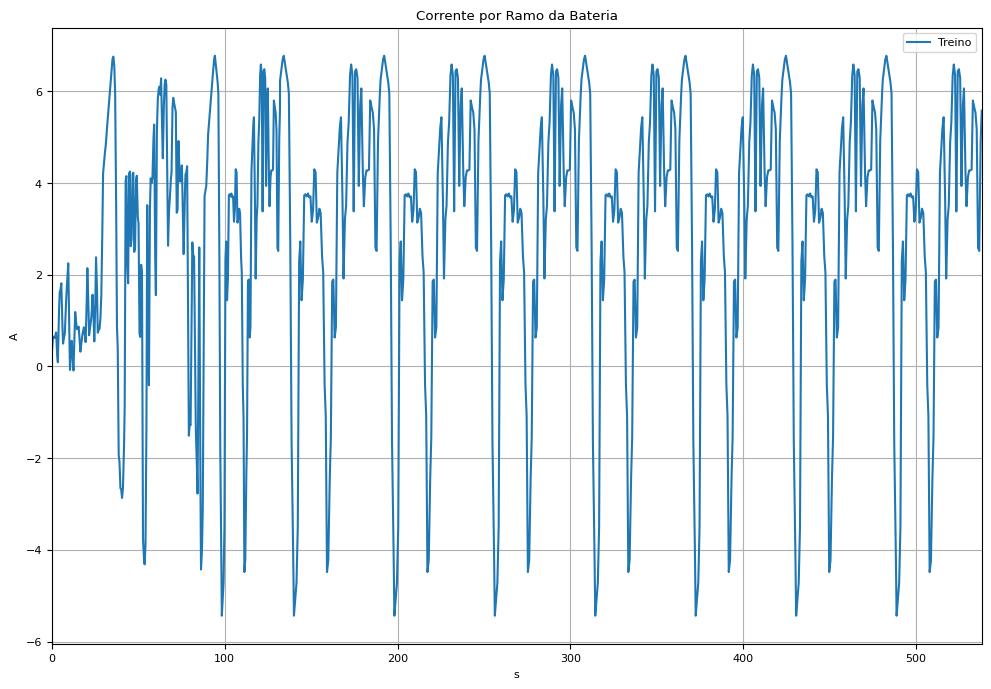

In [ ]:
# Plot Corrente
plt.figure(figsize=Fig_tamanho)
plt.rcParams.update({'font.size': 8})
plt.plot(t_Treino, Corrente_Celula_Treino, label="Treino")
plt.ylabel(r"A")
plt.xlabel(r"$\mathrm{s}$")
plt.xlim([t_Treino[0], t_Treino[-1]])
# plt.xlim([8.5, 9])
plt.grid()
plt.title("Corrente por Ramo da Bateria")
plt.legend()
plt.show()

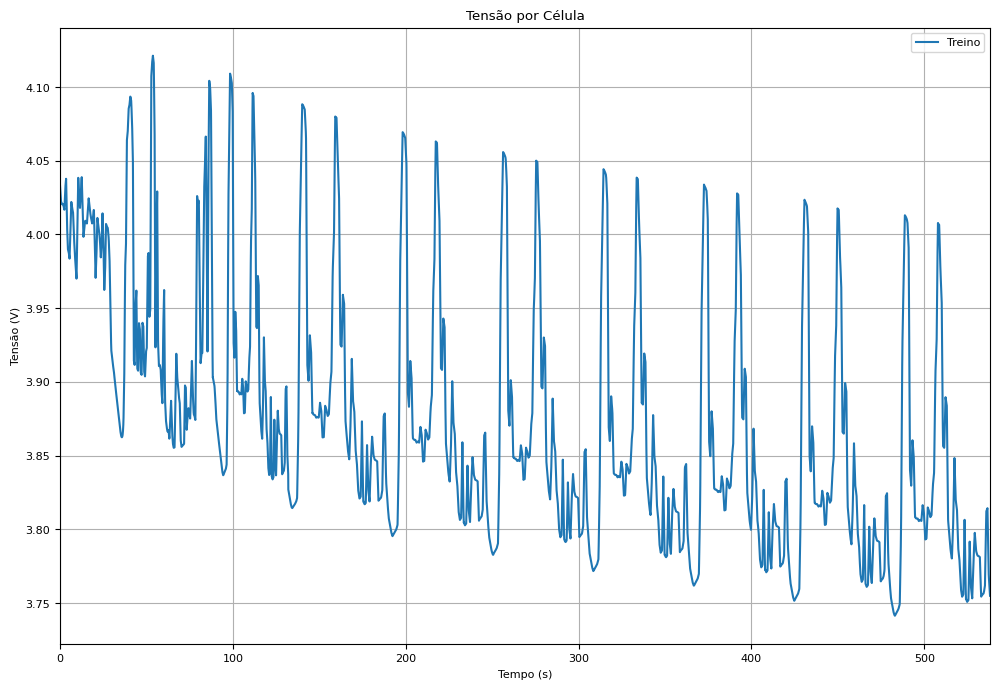

In [ ]:
# Plot Tensão
plt.figure(figsize=Fig_tamanho)
plt.rcParams.update({'font.size': 8})
plt.plot(t_Treino, Tensao_Celula_Treino, label="Treino")
plt.ylabel(r"Tensão (V)")
plt.xlabel(r"Tempo (s)")
plt.xlim([t_Treino[0], t_Treino[-1]])
# plt.xlim([8.5, 9])
plt.grid()
plt.title("Tensão por Célula")
plt.legend()
plt.show()

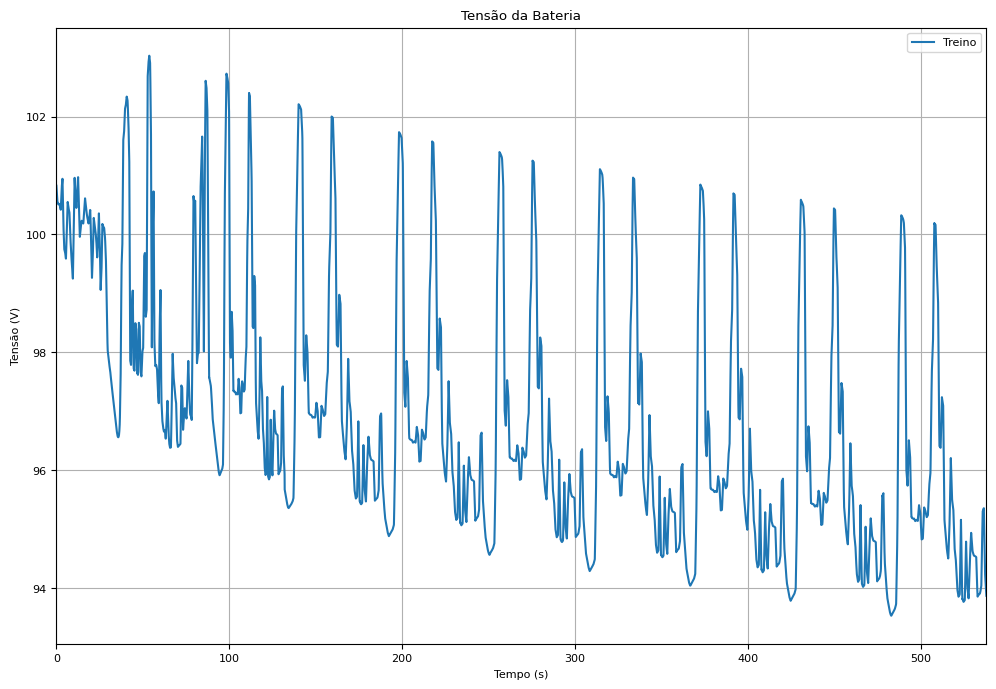

In [ ]:
# Plot Tensão Pack
plt.figure(figsize=Fig_tamanho)
plt.rcParams.update({'font.size': 8})
plt.plot(t_Treino, Tensao_Celula_Treino*25, label="Treino")
plt.ylabel(r"Tensão (V)")
plt.xlabel(r"Tempo (s)")
plt.xlim([t_Treino[0], t_Treino[-1]])
# plt.xlim([8.5, 9])
plt.grid()
plt.title("Tensão da Bateria")
plt.legend()
plt.show()

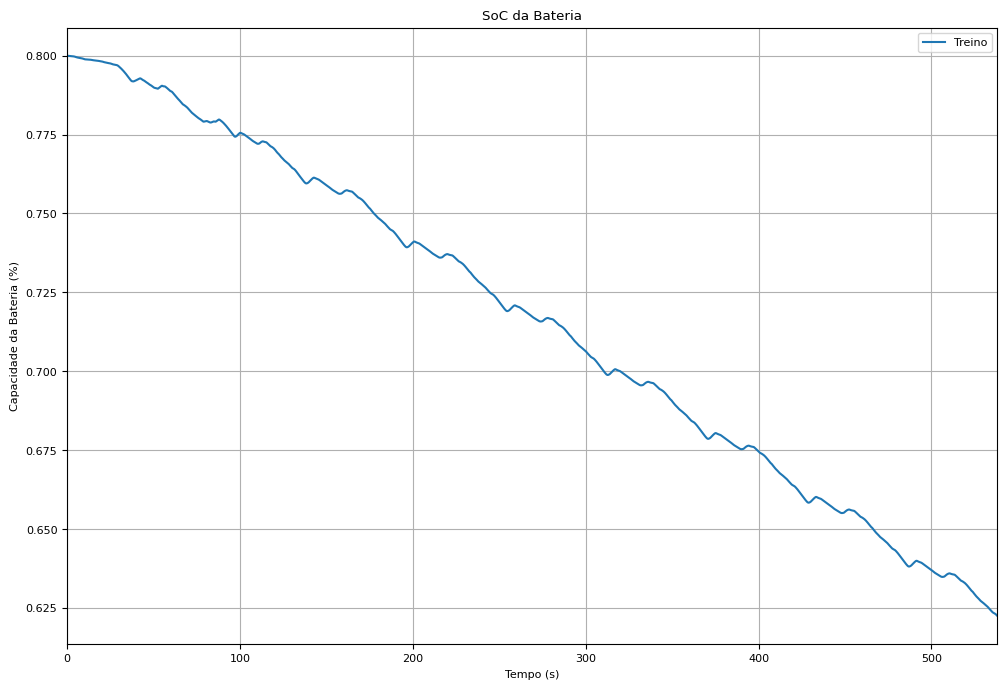

0.6224897895671079


In [ ]:
SoC_Treino = 0.8 - Capacidade_Treino/2.5
# Plot SoC
plt.figure(figsize=Fig_tamanho)
plt.rcParams.update({'font.size': 8})
plt.plot(t_Treino, SoC_Treino, label="Treino")
plt.ylabel(r"Capacidade da Bateria (%)")
plt.xlabel(r"Tempo (s)")
plt.xlim([t_Treino[0], t_Treino[-1]])
# plt.xlim([8.5, 9])
plt.grid()
plt.title("SoC da Bateria")
plt.legend()
plt.show()
SoC_final_Treino = SoC_Treino[-1]

print(SoC_Treino[-1])

In [ ]:
import scipy.integrate as integrate

capacidade_nominal_coulombs = 2.5 * 3600

carga_transferida = integrate.cumtrapz(Total_Corrida, Total_tempo, initial=0)

soc_integral = 0.8 - carga_transferida / capacidade_nominal_coulombs
# soc_integral = carga_transferida/3600

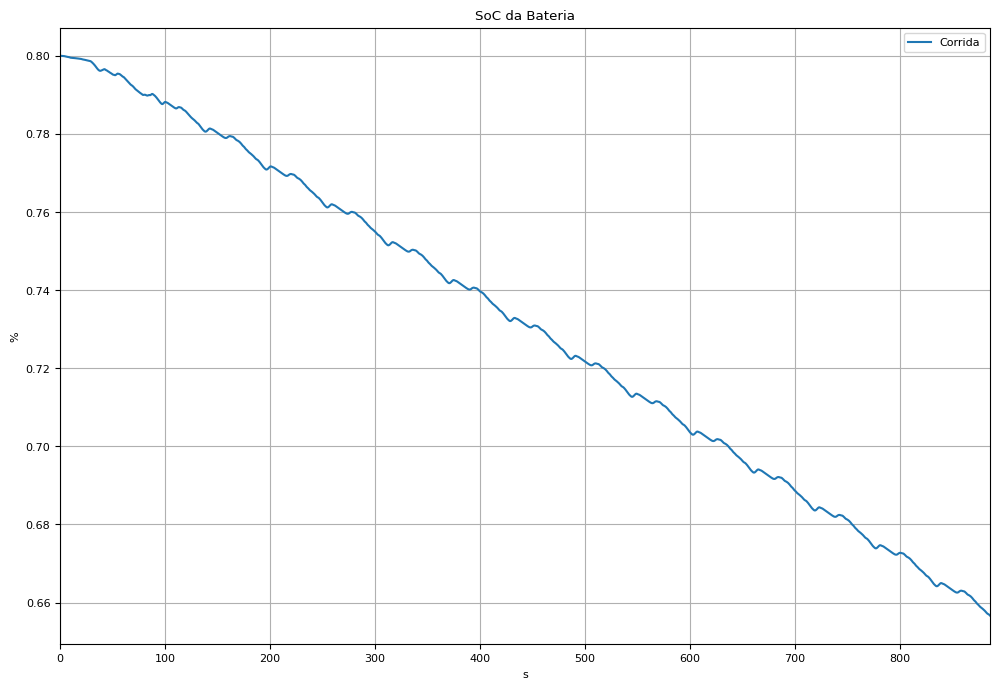

0.6566300860908657


In [ ]:
# Plot SoC
plt.figure(figsize=Fig_tamanho)
plt.rcParams.update({'font.size': 8})
plt.plot(Total_tempo, soc_integral, label="Corrida")
plt.ylabel(r"%")
plt.xlabel(r"$\mathrm{s}$")
plt.xlim([Total_tempo[0], Total_tempo[-1]])
# plt.xlim([8.5, 9])
plt.grid()
plt.title("SoC da Bateria")
plt.legend()
plt.show()

print(SoC[-1])

In [ ]:
Corrente_Celula_Corrida = solution['Current [A]'].entries
Capacidade_Corrida = solution['Discharge capacity [A.h]'].entries
Tensao_Celula_Corrida = solution['Voltage [V]'].entries
t_Corrida = solution["Time [s]"].entries

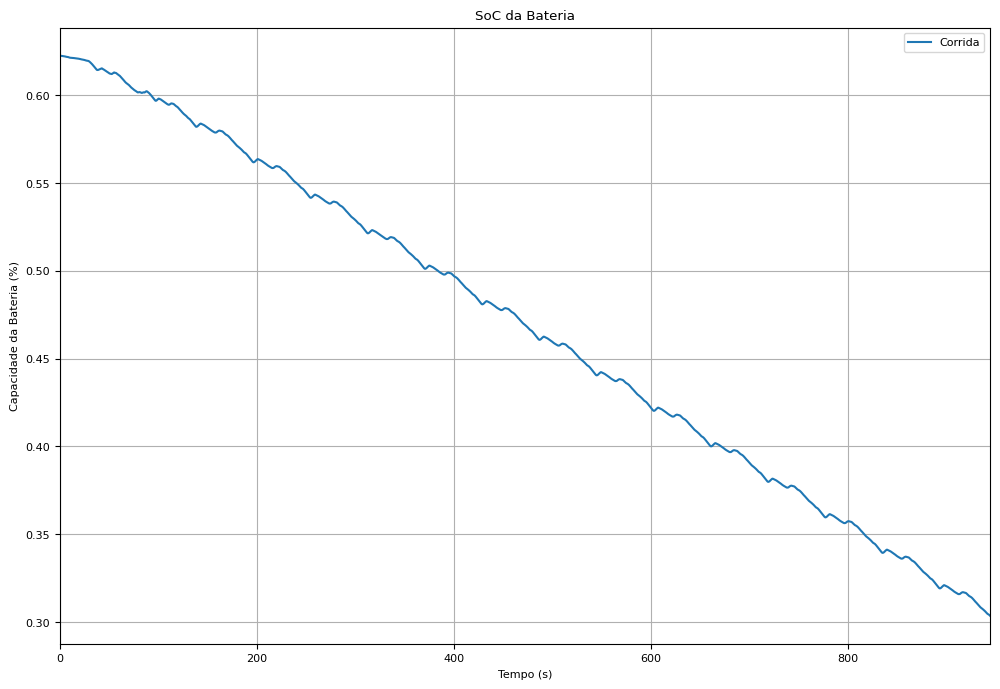

0.3035530996666137


In [ ]:
SoC_Corrida = SoC_final_Treino - Capacidade_Corrida/2.5
# Plot SoC
plt.figure(figsize=Fig_tamanho)
plt.rcParams.update({'font.size': 8})
plt.plot(t_Corrida, SoC_Corrida, label="Corrida")
plt.ylabel(r"Capacidade da Bateria (%)")
plt.xlabel(r"Tempo (s)")
plt.xlim([t_Corrida[0], t_Corrida[-1]])
# plt.xlim([8.5, 9])
plt.grid()
plt.title("SoC da Bateria")
plt.legend()
plt.show()
SoC_final_Corrida = SoC_Corrida[-1]

print(SoC_Corrida[-1])

In [ ]:
np.save('Bateria_Corrente_Celula_Corrida.npy', Corrente_Celula_Corrida)
np.save('Bateria_t_Corrida.npy', t_Corrida)
np.save('Bateria_Capacidade_Corrida.npy', Capacidade_Corrida)
np.save('Bateria_Tensao_Celula_Corrida.npy', Tensao_Celula_Corrida)
np.save('Bateria_SoC_Final_Corrida.npy', SoC_final_Corrida)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
Fig_tamanho = (12, 8)
Corrente_Celula_Corrida = np.load('Bateria_Corrente_Celula_Corrida.npy')
t_Corrida = np.load('Bateria_t_Corrida.npy')
Capacidade_Treino = np.load('Bateria_Capacidade_Corrida.npy')
Tensao_Celula_Corrida = np.load('Bateria_Tensao_Celula_Corrida.npy')
SoC_Final_Corrida = np.load('Bateria_SoC_Final_Corrida.npy')

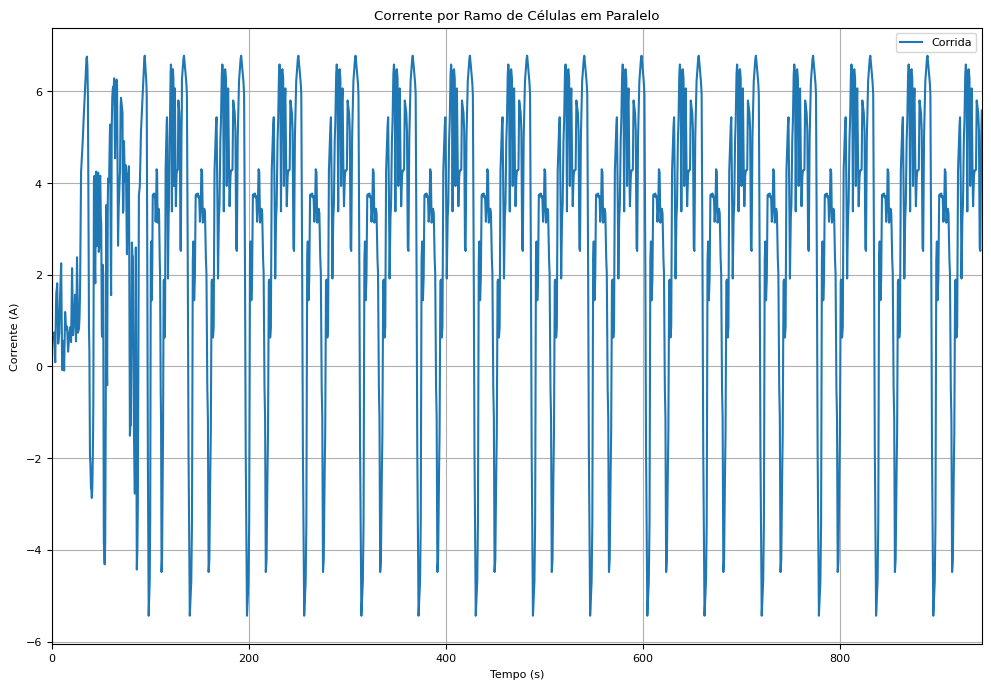

In [ ]:
# Plot Corrente
plt.figure(figsize=Fig_tamanho)
plt.rcParams.update({'font.size': 8})
plt.plot(t_Corrida, Corrente_Celula_Corrida, label="Corrida")
plt.ylabel(r"Corrente (A)")
plt.xlabel(r"Tempo (s)")
plt.xlim([t_Corrida[0], t_Corrida[-1]])
# plt.xlim([8.5, 9])
plt.grid()
plt.title("Corrente por Ramo de Células em Paralelo")
plt.legend()
plt.show()

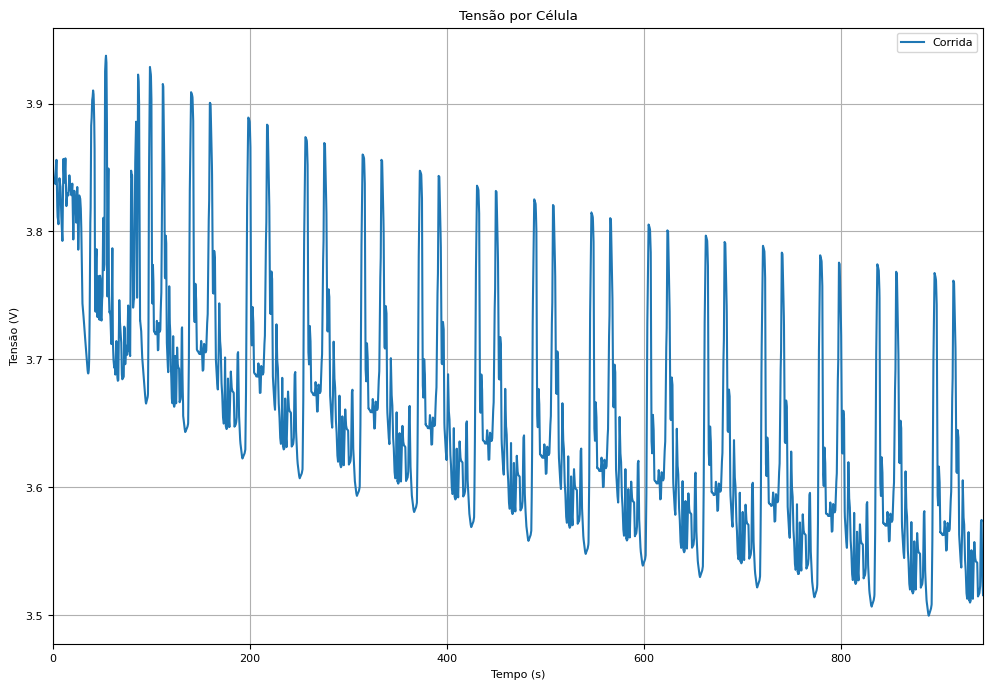

In [ ]:
# Plot Tensão
plt.figure(figsize=Fig_tamanho)
plt.rcParams.update({'font.size': 8})
plt.plot(t_Corrida, Tensao_Celula_Corrida, label="Corrida")
plt.ylabel(r"Tensão (V)")
plt.xlabel(r"Tempo (s)")
plt.xlim([t_Corrida[0], t_Corrida[-1]])
# plt.xlim([8.5, 9])
plt.grid()
plt.title("Tensão por Célula")
plt.legend()
plt.show()

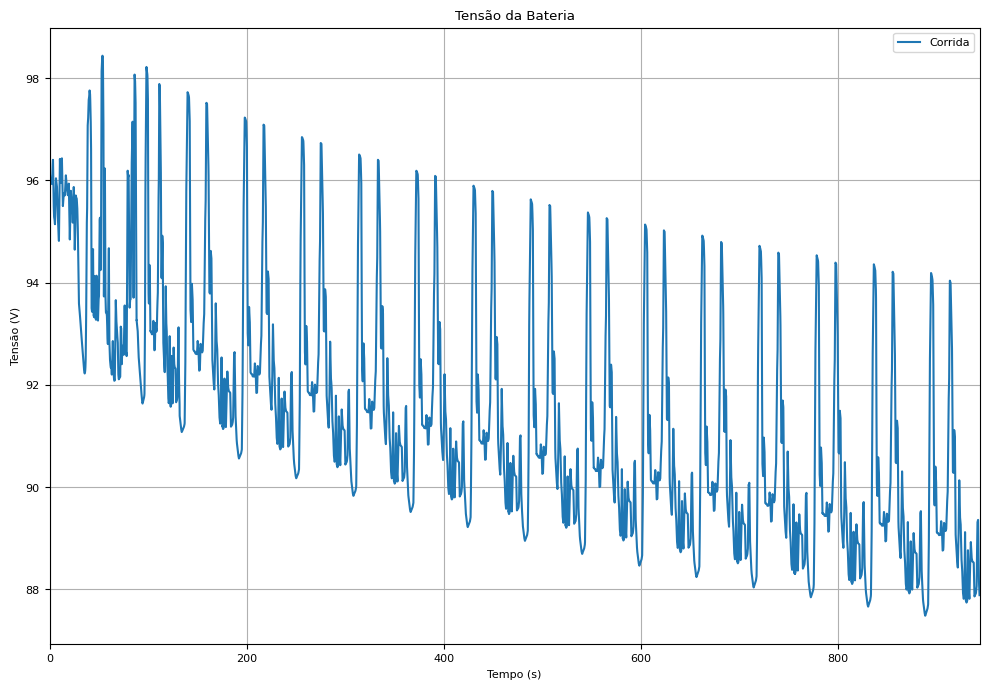

In [ ]:
# Plot Tensão
plt.figure(figsize=Fig_tamanho)
plt.rcParams.update({'font.size': 8})
plt.plot(t_Corrida, Tensao_Celula_Corrida*25, label="Corrida")
plt.ylabel(r"Tensão (V)")
plt.xlabel(r"Tempo (s)")
plt.xlim([t_Corrida[0], t_Corrida[-1]])
# plt.xlim([8.5, 9])
plt.grid()
plt.title("Tensão da Bateria")
plt.legend()
plt.show()

In [ ]:
# Generate the netlist
netlist = lp.setup_circuit(Np=20, Ns=25, Ri=5e-2, V=4.2, I=1.0)
model = pybamm.lithium_ion.DFN()

parameter_values = pybamm.ParameterValues("Chen2020")

parameter_values.update(
    {"Number of cells connected in series to make a battery": 1})
parameter_values.update(
    {"Number of electrodes connected in parallel to make a cell": 1})
parameter_values.update(
    {"Open-circuit voltage at 0% SOC [V]": 2.5})
parameter_values.update(
    {"Open-circuit voltage at 100% SOC [V]": 4.2})
parameter_values.update(
    {"Nominal cell capacity [A.h]": 2.5})
parameter_values.update(
    {"Current function [A]": Total_Corrida/20})

# drive_cycle_power = np.column_stack([reduced_timer, reduced_vector])
drive_cycle_power = np.column_stack([tempo_corrida, Corrida])
# drive_cycle_power = np.column_stack([Total_tempo, Total_Corrida_R])
experiment = pybamm.Experiment([pybamm.step.current(drive_cycle_power)],
    period="0.5 second")# Para 100x 0.1     para 1000x 1   para 500x 0.5

output_d = lp.solve(
    netlist=netlist,
    parameter_values=parameter_values,
    experiment=experiment,
    initial_soc=0.8,
    # output_variables=output_variables,
)


# fast_solver = pybamm.CasadiSolver(atol=1e-3, rtol=1e-4, mode="fast")

# sim = pybamm.Simulation(model, experiment=experiment, parameter_values=parameter_values, solver = fast_solver)#, output_variables=output_variables)

# sim.solve(initial_soc=1)

# solution = sim.solution

Stepping simulation: 100%|██████████| 553/553 [05:26<00:00,  1.70it/s]


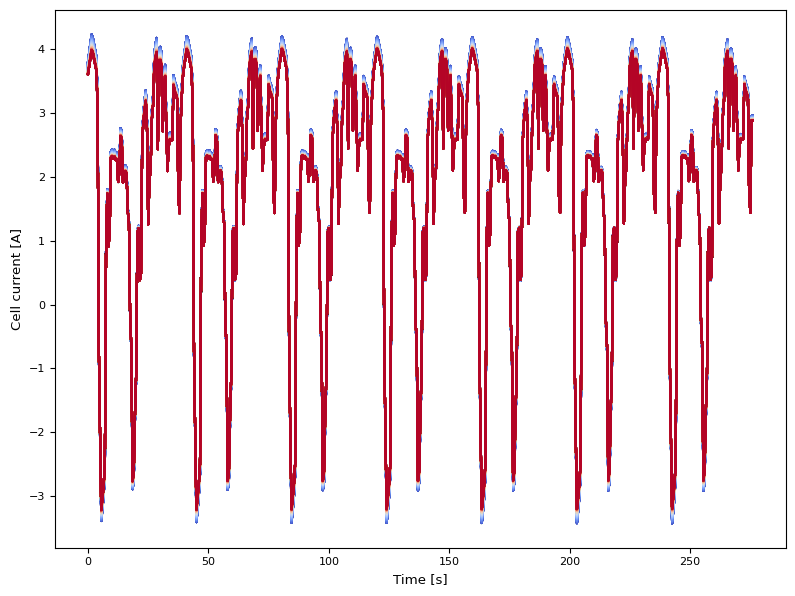

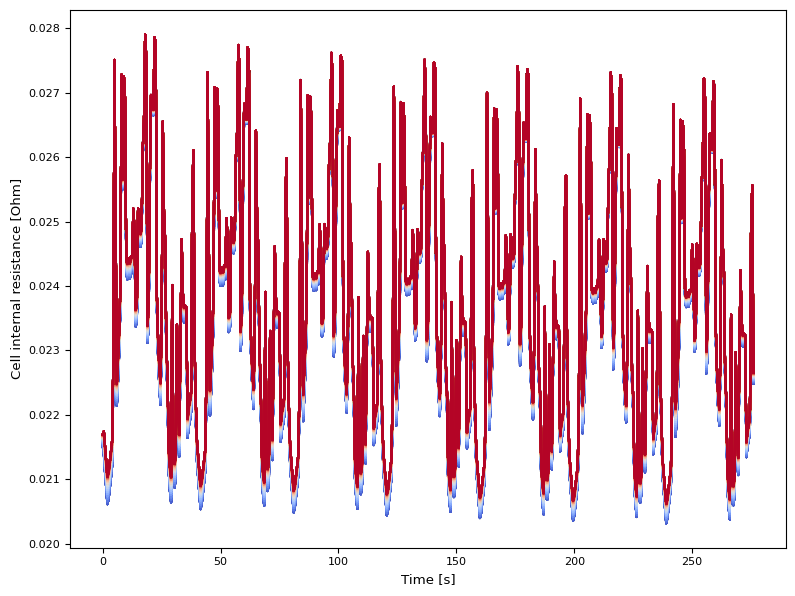

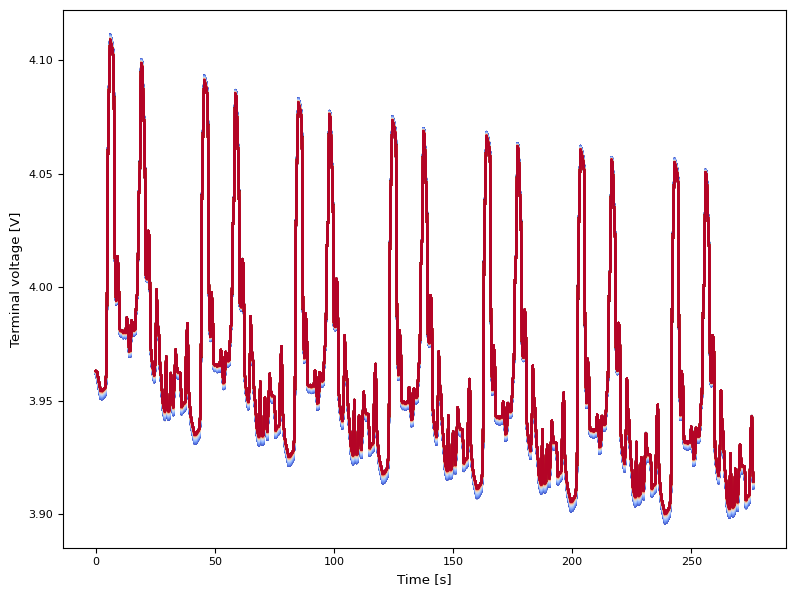

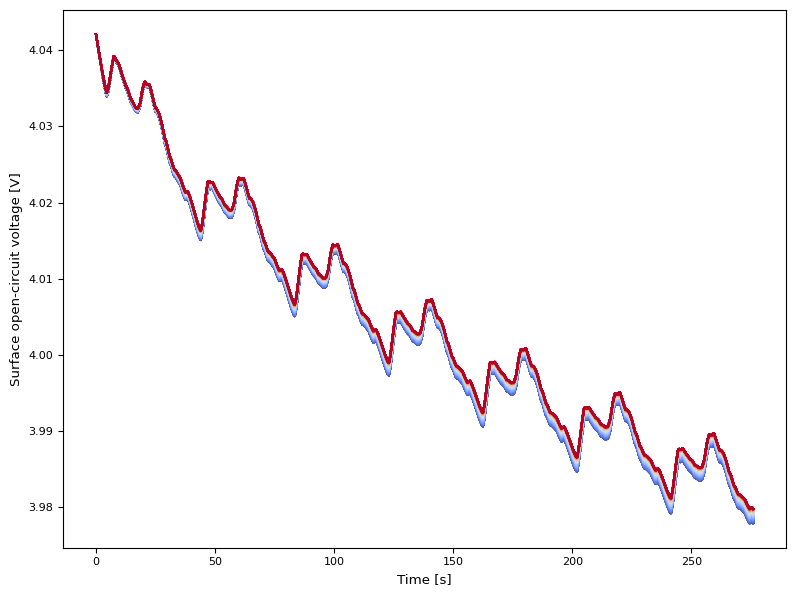

In [ ]:
lp.plot_cells(output_d,color='white')
lp.show_plots()

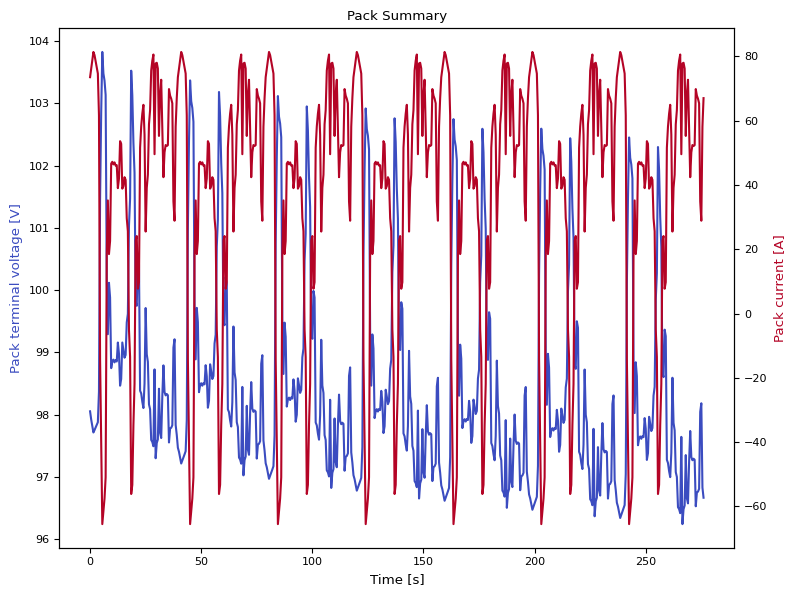

In [ ]:
lp.plot_pack(output_d,color='white')
lp.show_plots()